In [5]:
import csv 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import json

In [4]:
debug_path = "results_ordinal/debug.csv"

with open(debug_path) as f1:
    reader = csv.DictReader(f1)
    data = [x for x in reader]

print(data[0].keys())


dict_keys(['HITId', 'HITTypeId', 'Title', 'CreationTime', 'MaxAssignments', 'AssignmentDurationInSeconds', 'AssignmentId', 'WorkerId', 'AcceptTime', 'SubmitTime', 'WorkTimeInSeconds', 'Input.answer', 'Input.img_url', 'Input.is_distractor', 'Input.qid', 'Input.question', 'Input.question_type', 'Answer.comments', 'Answer.radio-input', 'Turkle.Username'])


In [9]:
# choice_mapping = {1: "yes", 2: "maybe", 3: "no"}
def parse_hit_data(data, choice_mapping = {1: 1, 2: 0, 3: 0}): 
    hit_data = []
    for row in data:
        qid = row['Input.qid']
        is_distractor = json.loads(row['Input.is_distractor'])
        question_type = json.loads(row['Input.question_type'])
        choice_idx = int(row['Answer.radio-input'])
        choice = choice_mapping[choice_idx]
        df_row = {"qid": qid, "is_distractor": is_distractor, "question_type": question_type, "choice": choice}
        hit_data.append(df_row)
    return pd.DataFrame(hit_data)

In [13]:
df_to_plot = parse_hit_data(data, combine_maybe_no=True)
print(df_to_plot)

            qid  is_distractor question_type  choice
0  "44463014_5"          False          pred       1
1  "44463014_5"           True          pred       2
2  "44463014_5"          False           ann       1
3  "44463014_5"           True           ann       2
4  "44463014_5"          False          orig       1
5  "44463014_5"           True          orig       1


<AxesSubplot:xlabel='question_type', ylabel='choice'>

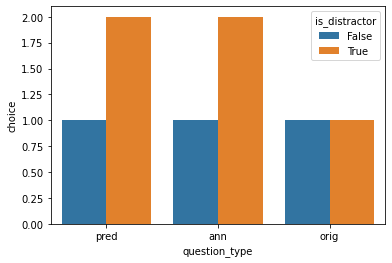

In [12]:
sns.barplot(data = df_to_plot, x = "question_type", y = "choice", hue = "is_distractor")